# Przygotowanie danych i środowiska

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark2.4.5
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# install findspark
!pip install -q findspark
# Google Colab has Java 11 available, test it using below command -
!ls /usr/lib/jvm
#install pyarrow
!pip install -U pyarrow
# Tietjen-Moore test package
!pip install scikit_posthocs

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_params = {
"spark.executor.memory" : "4g",
"spark.driver.memory": "4g",
"spark.memory.fraction": "0.9"}
for param, value in spark_params.items():
  spark.conf.set(param, value)

!wget "https://datasets.imdbws.com/title.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.ratings.tsv.gz"

title_ratings = spark.read.csv("title.ratings.tsv.gz", sep='\t', header=True)
title_basics = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)

--2022-11-11 17:50:37--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.227.219.93, 13.227.219.51, 13.227.219.78, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.227.219.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163667534 (156M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz.2’

title.basics.tsv.gz 100%[===================>] 156.08M  38.5MB/s    in 4.2s    

2022-11-11 17:50:41 (37.2 MB/s) - ‘title.basics.tsv.gz.2’ saved [163667534/163667534]

--2022-11-11 17:50:41--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.227.219.93, 13.227.219.51, 13.227.219.78, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.227.219.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6258233 (6.0M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz.2’

title.ratings.tsv.g 100%[===============

In [3]:
print(title_basics.show(5))
print(title_ratings.show(5))

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean, stdev

from scipy.stats import kstest, pearsonr, chisquare
from scipy.stats.mstats import winsorize

In [5]:
def compare_with_normal_dist(sample):
  # Create a gaussian distribution
  m = mean(sample)
  sd = stdev(sample)
  x = np.random.normal(loc = m, scale = sd, size = len(sample))

  # Binning
  n_x, bins_x = np.histogram(x, bins = int(np.ceil(np.sqrt(x.size))))
  n_y, bins_y = np.histogram(sample, bins = int(np.ceil(np.sqrt(len(sample)))))

  # Normalizings
  n_x = n_x / len(x) / len(bins_y)
  n_y = n_y / len(sample) / len(bins_x)

  # Plotting
  plt.plot(bins_x[:-1], n_x)
  plt.plot(bins_y[:-1], n_y)
  plt.show()  

def histogram(sample, title_lab=None):
  plt.hist(sample)
  plt.title(title_lab)
  plt.show() 

def pearson_corr_test(vec1, vec2):
  stat, p = pearsonr(vec1, vec2)
  print(f'Statistic: {stat}, p-value: {p}')

# Testy normalności 

Przygotwanie odpowiednich wartości liczbowych

In [6]:
to_filter = ['\\N', 'Reality-TV', 'Talk-Show', 'Documentary', 
             'Animation,Comedy,Family', 'Game-Show', 'Game-Show,Reality-TV']

runtime = (title_basics.select('runtimeMinutes').
           filter(~title_basics.runtimeMinutes.isin(to_filter)))
runtime = list(runtime.toPandas()['runtimeMinutes'])
runtime = [float(x) for x in runtime]

ratings = list(title_ratings.select('averageRating').toPandas()['averageRating'])
ratings = [float(x) for x in ratings]

votes = list(title_ratings.select('numVotes').toPandas()['numVotes'])
votes = [float(x) for x in votes]

Rozkład ocen filmów

KstestResult(statistic=0.07659309852981872, pvalue=0.0)
mean: 6.949892651006658, standard deviation: 1.3901667315318438


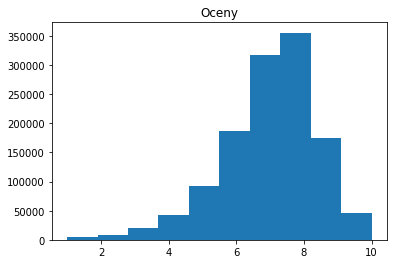

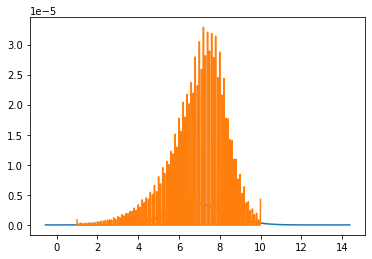

In [7]:
m_r = mean(ratings)
sd_r = stdev(ratings)

print(kstest([(x - m_r) / sd_r for x in ratings], "norm"))
print(f"mean: {m_r}, standard deviation: {sd_r}")

histogram(ratings, 'Oceny')
compare_with_normal_dist(ratings)

Rozkład liczby ocen

KstestResult(statistic=0.47607165858893874, pvalue=0.0)
mean: 1042.0391711502389, standard deviation: 17279.532232500063


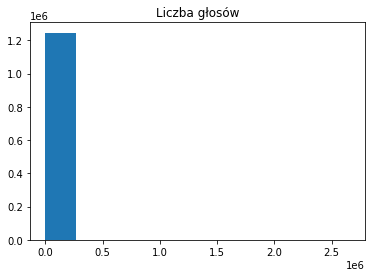

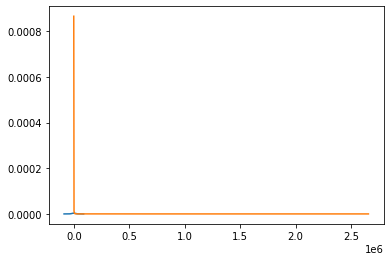

In [8]:
m_v = mean(votes)
sd_v = stdev(votes)

print(kstest([(x - m_v) / sd_v for x in votes], "norm"))
print(f"mean: {m_v}, standard deviation: {sd_v}")

histogram(votes, 'Liczba głosów')
compare_with_normal_dist(votes)

Rozkład czasu trwania

KstestResult(statistic=0.2927393306039908, pvalue=0.0)
mean: 43.89264214594141, standard deviation: 78.64589211096042


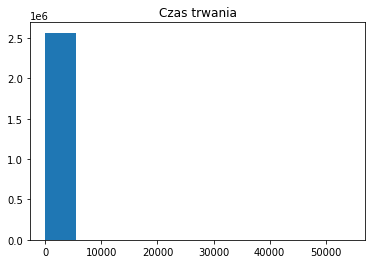

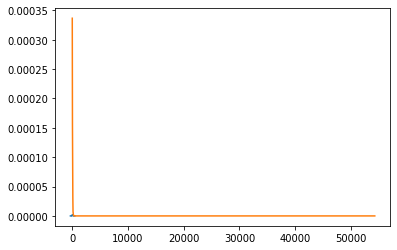

In [9]:
m_t = mean(runtime)
sd_t = stdev(runtime)

print(kstest([(x - m_t) / sd_t for x in runtime], "norm"))
print(f"mean: {m_t}, standard deviation: {sd_t}")

histogram(runtime, 'Czas trwania')
compare_with_normal_dist(runtime)

Histogramy oraz przeprowadzone testy statystyczne sugerują, że dane nie pochodzą z rozkładu normlanego. Dla liczby ocen oraz czasu trwania wystepują obserwacje które skrajnie różnią się od średniej w danej próbce. Obserwacje te powodują, że p-value dla testów Kolomogorowa-Smirnova jest bliskie zeru.

# Analiza wartości odstających

Usuwamy obserwacje które leża dalej niż 3*odchylenie standardowe od średniej

In [10]:
ratings_cut = [x for x in ratings if (x > m_r - 3 * sd_r) and (x < m_r + 3 * sd_r)]
votes_cut = [x for x in votes if (x > m_v - 3 * sd_v) and (x < m_v + 3 * sd_v)]
runtime_cut = [x for x in runtime if (x > m_t - 3 * sd_t) and (x < m_t + 3 * sd_t)]

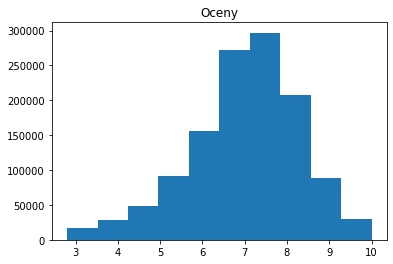

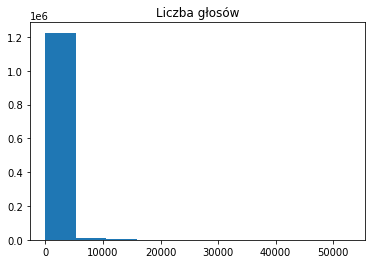

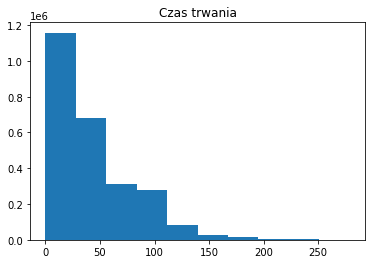

In [11]:
histogram(ratings_cut, 'Oceny')
histogram(votes_cut, 'Liczba głosów')
histogram(runtime_cut, 'Czas trwania')

Widzimy, że dla liczby głosów taka korekta nie jest wystarczająca. Nadal istnieją filmy które posiadają kilka tysięcy ocen, podczas gdy większość filmów ma mnije niż 2500 ocen.

W tej metodzie nie usuwamy wartości skrajnych lecz mapujemy je na wartości kwantyla 1% i 99%.

In [12]:
ratings_win = winsorize(ratings, limits=[0.01, 0.01])
votes_win = winsorize(votes, limits=[0.01, 0.01])
runtime_win = winsorize(runtime, limits=[0.01, 0.01])

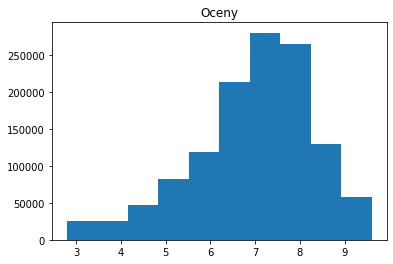

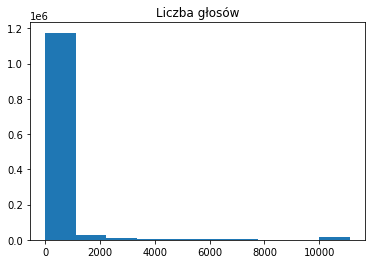

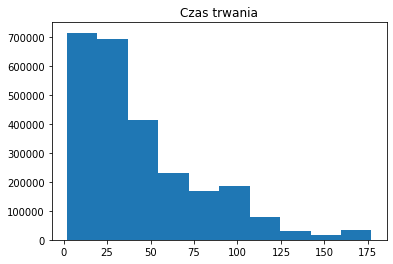

In [13]:
histogram(ratings_win, 'Oceny')
histogram(votes_win, 'Liczba głosów')
histogram(runtime_win, 'Czas trwania')

Metoda może być użyta dla czasu trwania i ocen jednak rozkład liczby głosów  dalej posiada wartości odstające. Prawdopodonie, aby dostać jendorodny rozkład, należałoby podzielić ten zbiór na grupy w zależności od np. regionu lub budżetu filmu.

# Analiza korelacji

In [14]:
data = title_basics.join(title_ratings, 
                         how='inner', 
                         on='tconst').select(['averageRating', 
                                              'numVotes', 
                                              'runtimeMinutes'])
data = data.filter(~data.runtimeMinutes.isin(to_filter))
data = data.distinct().toPandas()
data = data.apply(pd.to_numeric)

In [15]:
print(data.corr())

                averageRating  numVotes  runtimeMinutes
averageRating        1.000000  0.031923       -0.054165
numVotes             0.031923  1.000000        0.027252
runtimeMinutes      -0.054165  0.027252        1.000000


In [16]:
pearson_corr_test(data.loc[:, 'numVotes'], data.loc[:, 'averageRating'])
pearson_corr_test(data.loc[:, 'numVotes'], data.loc[:, 'runtimeMinutes'])
pearson_corr_test(data.loc[:, 'runtimeMinutes'], data.loc[:, 'averageRating'])

Statistic: 0.031922764782960286, p-value: 4.45857511691228e-114
Statistic: 0.027252006062312508, p-value: 1.1950491399249539e-83
Statistic: -0.054164799011934425, p-value: 0.0


Macierz korelacji oraz przeprwoadzone testy sugerują brak korelacji między liczbą głosów, średnią oceną i czasem trwania.

# Testy jednorodności

In [17]:
chisquare(data.loc[:, 'numVotes'], data.loc[:, 'averageRating'])

ValueError: ignored